In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import gc
import random
import tqdm.notebook as tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio

from torch.utils.tensorboard import SummaryWriter
from tensorboard.backend.event_processing import event_accumulator

from transformers import (
    AutoFeatureExtractor,
    ASTForAudioClassification
)

from utils import compute_score, train, test

%matplotlib inline

In [33]:
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED) 
    torch.manual_seed(SEED) 
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  
    os.environ['PYTHONHASHSEED'] = str(SEED)
set_seed(42)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Просмотр данных и формирование датасета

In [35]:
DIR_TRAIN = "crowd/crowd_train/"
DIR_VAL = "crowd/crowd_train/"
DIR_TEST = "crowd/crowd_test/"

PATH_TRAIN = "train.csv"
PATH_VAL = "val.csv"
PATH_TEST = "test.csv"

df_train = pd.read_csv(PATH_TRAIN)
df_val = pd.read_csv(PATH_VAL)
df_test = pd.read_csv(PATH_TEST)

print("В обучающей выборке {} аудиозаписей".format(len(df_train)))
print("В валидационной выборке {} аудиозаписей".format(len(df_val)))
print("В тестовой выборке {} аудиозаписей".format(len(df_test)))

В обучающей выборке 6864 аудиозаписей
В валидационной выборке 932 аудиозаписей
В тестовой выборке 815 аудиозаписей


In [36]:
class EmotionDataset(Dataset):
    def __init__(self, train_df, val_df, test_df):
        """
        Аргументы:
            train_df, val_df, test_df (pd.DataFrame): тренировочный, валидационный и тестовый наборы данных
        """
        
        self.train_df = train_df
        self.train_size = len(self.train_df)
        
        self.val_df = val_df
        self.val_size = len(self.val_df)
        
        self.test_df = test_df
        self.test_size = len(self.test_df)
        
        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.val_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train') 
    
    @classmethod
    def load_dataset(cls, path_train, path_val, path_test, features_dir=None, 
                     dir_train=None, dir_val=None, dir_test=None,
                     feature_extractor=None, load_features=True, save_features=False):
        """Загрузка данных датасета
        Аргументы:
            path_train, path_val, path_test (str): пути к тренировочному, валидационному и тестовому наборам данных
            features_dir (str): директория признаков аудиозаписей
            dir_train, dir_val, dir_test (str): директории с аудиозаписями
            feature_extractor (): объект класса, извлекающего признаки из аудиозаписи
            load_features (bool): True -> загрузка выделенных ранее признаков, 
                                  False -> выделение признаков из аудиозаписей
            save_featurees (bool): True -> сохранение выделенных признаков в features_dir
        Возвращает:
            экземпляр EmotionDataset
        """
        #загрузка данных
        train_df = pd.read_csv(path_train)
        val_df = pd.read_csv(path_val)
        test_df = pd.read_csv(path_test)
        
        #загрузка признаков
        if load_features:
            features = cls._load_features(train_df, 'train', features_dir)
            train_df.insert(len(train_df.columns), 'features', features)

            features = cls._load_features(val_df, 'val', features_dir)
            val_df.insert(len(val_df.columns), 'features', features)

            features = cls._load_features(test_df, 'test', features_dir)
            test_df.insert(len(test_df.columns), 'features', features)
        
        #векторизация аудиозаписей и сохранение признаков
        else:
            
            features = cls._extract_features(train_df, dir_train, feature_extractor,
                                             'train', features_dir, save_features)
            train_df.insert(len(train_df.columns), 'features', features)

            features = cls._extract_features(val_df, dir_val, feature_extractor, 
                                             'val', features_dir, save_features)
            val_df.insert(len(val_df.columns), 'features', features)
            
            features = cls._extract_features(test_df, dir_test, feature_extractor, 
                                             'test', features_dir, save_features)
            test_df.insert(len(test_df.columns), 'features', features)
        
        return cls(train_df, val_df, test_df)
    
    def _extract_features(df, files_dir, feature_extractor, mode, features_dir=None, save_features=False):
        """Выделение признаков
        """
        features = []
        pbar = tqdm.tqdm(range(len(df['hash_id'])), total=len(df['hash_id']))
        pbar.set_description(mode + ' dataset loading')
        
        if save_features and not os.path.exists(features_dir + mode):
            os.makedirs(features_dir + mode)
        
        for i in pbar:
            waveform, sampling_rate = torchaudio.load(files_dir + df['audio_path'][i])
            waveform = waveform.squeeze().numpy()
            feature = feature_extractor(waveform, sampling_rate).input_values[0]
            features.append(feature)
            if save_features:
                np.save('{0}{1}/{2}.npy'.format(features_dir, mode, df['hash_id'][i]), feature)
        return features
    
    def _load_features(df, mode, features_dir):
        """Загрузка ранее выделенных признаков
        """
        features = []
        pbar = tqdm.tqdm(range(len(df['hash_id'])), total=len(df['hash_id']))
        pbar.set_description(mode + ' dataset loading')
        for i in pbar:
            feature = np.load('{0}{1}/{2}.npy'.format(features_dir, mode, df['hash_id'][i]))
            features.append(feature)
        return features
        
    def set_split(self, split="train"):
        """Выбор фрагментов набора данных по столбцу из объекта dataframe
        Аргументы:
            split (str): "train"/"val"/"test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[self._target_split]

    def __getitem__(self, idx):
        row = self._target_df.iloc[idx]
        return {"features": row['features'],
                "class": row['emotion']}

    def __len__(self):
        return self._target_size

## Дообучение Audio Spectrogram Transformer (AST)

### Загрузка датасета

In [37]:
MODEL_PATH = "MIT/ast-finetuned-audioset-10-10-0.4593"
CLASSES = ['positive', 'sad', 'angry', 'neutral']
DIR_FEATURES = 'ast_features/'
EXPERIMENT_DIR = 'ast_experiments/'

In [38]:
auto_feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_PATH)
feature_extractor = lambda waveform, sampling_rate: auto_feature_extractor(waveform, sampling_rate=sampling_rate, 
                                                                           return_tensors="np")
ds = EmotionDataset.load_dataset(PATH_TRAIN, PATH_VAL, PATH_TEST, features_dir=DIR_FEATURES,
                                 #dir_train=DIR_TRAIN, dir_val=DIR_VAL, dir_test=DIR_TEST, 
                                 #feature_extractor = feature_extractor, load_features=False, save_features=True)
                                 feature_extractor = feature_extractor, load_features=True)
                                 

  0%|          | 0/6864 [00:00<?, ?it/s]

  0%|          | 0/932 [00:00<?, ?it/s]

  0%|          | 0/815 [00:00<?, ?it/s]

### Параметры экспериментов

| № |  Optimizer | Base lr | Scheduler | Epoch |
| --- | :-- | --- | :-- | --- |
| 1 | Adam | 1e-5 | После 2 эпохи lr уменьшается в 2 раза каждую эпоху | 5 |
| 2 | Adam | 1e-6 | После 2 эпохи lr уменьшается в 2 раза каждую эпоху | 5 |
| 3 | *Для трансформера*: Adam<br>*Для классификатора*: AdamW | 1e-5 | *Для трансформера*: после 2 эпохи lr уменьшается в 2 раза каждую эпоху<br>*Для классификатора*: постоянный lr | 5 |
| 4 | *Для трансформера*: Adam<br>*Для классификатора*: AdamW | 1e-6 | *Для трансформера*: после 2 эпохи lr уменьшается в 2 раза каждую эпоху<br>*Для классификатора*: постоянный lr | 5 |
| 5 | *Для классификатора*: Adam | 1e-5 | *Для классификатора*: после 2 эпохи lr уменьшается в 2 раза каждую эпоху | 5 |
| 6 | *Для классификатора*: Adam | 1e-2 | *Для классификатора*: после 2 эпохи lr уменьшается в 2 раза каждую эпоху | 5 |
| 7 | *Для классификатора*: Adam | 5e-2 | *Для классификатора*: после 2 эпохи lr уменьшается в 2 раза каждую эпоху | 5 |
| 8 | *Для классификатора*: Adam | 1e-1 | *Для классификатора*: после 2 эпохи lr уменьшается в 2 раза каждую эпоху | 5 |
| 9 | *Для классификатора*: AdamW | 1e-2 | *Для классификатора*: после 2 эпохи lr уменьшается в 2 раза каждую эпоху | 5 |
| 10 | *Для классификатора*: Adam | 1e-2 | *Для классификатора*: постоянный lr | 5 |
| 11 | *Для классификатора*: AdamW | 1e-2 | *Для классификатора*: постоянный lr | 5 |
| 12 | *Для классификатора*: AdamW | 1e-2 | *Для классификатора*: после 2 эпохи lr уменьшается в 2 раза каждую 2-ую эпоху | 5 |
| 13 | *Для классификатора*: AdamW | 1e-1 | *Для классификатора*: после 2 эпохи lr уменьшается в 2 раза каждую 2-ую эпоху | 5 |
| 14 | *Для классификатора*: Adam | 1e-2 | *Для классификатора*: после 2 эпохи lr уменьшается на 1/4 каждую эпоху | 5 |
| 15 | *Для классификатора*: Adam | 5e-1 | *Для классификатора*: после 2 эпохи lr уменьшается на 1/4 каждую эпоху | 5 |

Размер батча задается с помощью двух параметров: `batch_size = BATCH_SIZE * GRAD_ACCUMULATION`.

### Код запуска эксперимента

In [ ]:
EPOCH = # number of epochs
BATCH_SIZE = 3
GRAD_ACCUMULATION=4
SEED = 42
EXP_NUM = # experiment number

set_seed(SEED)
    
model = ASTForAudioClassification.from_pretrained(MODEL_PATH, num_labels=len(CLASSES), 
                                                  return_dict=False, ignore_mismatched_sizes=True)
model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = [optim.Adam(model.parameters(), lr=1e-5)]
sсheduler = [optim.lr_scheduler.MultiStepLR(optimizer[0], milestones=np.arange(2, EPOCH), gamma=0.5)]

writer =  SummaryWriter("{0}runs/exp{1}".format(EXPERIMENT_DIR, EXP_NUM))
writer.add_graph(model, input_to_model=torch.Tensor(np.array([ds[i]['features'] 
                                                              for i in range(BATCH_SIZE)])).to(device, torch.float32))

train(model, ds, loss_func, optimizer, sсheduler, EPOCH, BATCH_SIZE, device, writer, CLASSES,
      "{0}checkpoints/exp{1}".format(EXPERIMENT_DIR, EXP_NUM), gradient_accumulation_steps=GRAD_ACCUMULATION)

writer.flush()
writer.close()

gc.collect()
torch.cuda.empty_cache()

### Анализ результатов

In [3]:
def experiment_plots(exp_nums, loss_ylim, score_ylim):
    def load_data(data_dir):
        ea_file = os.listdir(data_dir)[0]
        ea=event_accumulator.EventAccumulator('{}/{}'.format(data_dir, ea_file)) 
        ea.Reload()
        return [item.value for item in ea.scalars.Items(ea.scalars.Keys()[-1])][:5]
    
    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 25))
    x = np.arange(5) + 1

    ax[0, 0].set(title='Train Loss', ylabel='loss', xlabel='epoch', ylim=loss_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/loss_train'.format(exp_num))
        ax[0, 0].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[0, 0].legend()
    ax[0, 0].grid()

    ax[0, 1].set(title='Validation Loss', ylabel='loss', xlabel='epoch', ylim=loss_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/loss_validation'.format(exp_num))
        ax[0, 1].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[0, 1].legend()
    ax[0, 1].grid()
    
    ax[1, 0].set(title='Accuracy (macro)', ylabel='score', xlabel='epoch', ylim=score_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/accuracy_macro_average_validation'.format(exp_num))
        ax[1, 0].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[1, 0].legend()
    ax[1, 0].grid()
    
    ax[1, 1].set(title='F1 (macro)', ylabel='score', xlabel='epoch', ylim=score_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/f1_macro_average_validation'.format(exp_num))
        ax[1, 1].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[1, 1].legend()
    ax[1, 1].grid()
    
    ax[2, 0].set(title='Precision (macro)', ylabel='score', xlabel='epoch', ylim=score_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/precision_macro_average_validation'.format(exp_num))
        ax[2, 0].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[2, 0].legend()
    ax[2, 0].grid()
    
    ax[2, 1].set(title='Recall (macro)', ylabel='score', xlabel='epoch', ylim=score_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/recall_macro_average_validation'.format(exp_num))
        ax[2, 1].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[2, 1].legend()
    ax[2, 1].grid()
    
    ax[3, 0].set(title='Positive', ylabel='f1 score', xlabel='epoch', ylim=score_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/f1_positive_validation'.format(exp_num))
        ax[3, 0].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[3, 0].legend()
    ax[3, 0].grid()
    
    ax[3, 1].set(title='Sad', ylabel='f1 score', xlabel='epoch', ylim=score_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/f1_sad_validation'.format(exp_num))
        ax[3, 1].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[3, 1].legend()
    ax[3, 1].grid()
    
    ax[4, 0].set(title='Angry', ylabel='f1 score', xlabel='epoch', ylim=score_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/f1_angry_validation'.format(exp_num))
        ax[4, 0].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[4, 0].legend()
    ax[4, 0].grid()
    
    ax[4, 1].set(title='Neutral', ylabel='f1 score', xlabel='epoch', ylim=score_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/f1_neutral_validation'.format(exp_num))
        ax[4, 1].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[4, 1].legend()
    ax[4, 1].grid()

    plt.show()

#### Группа 1: эксперименты 1-4

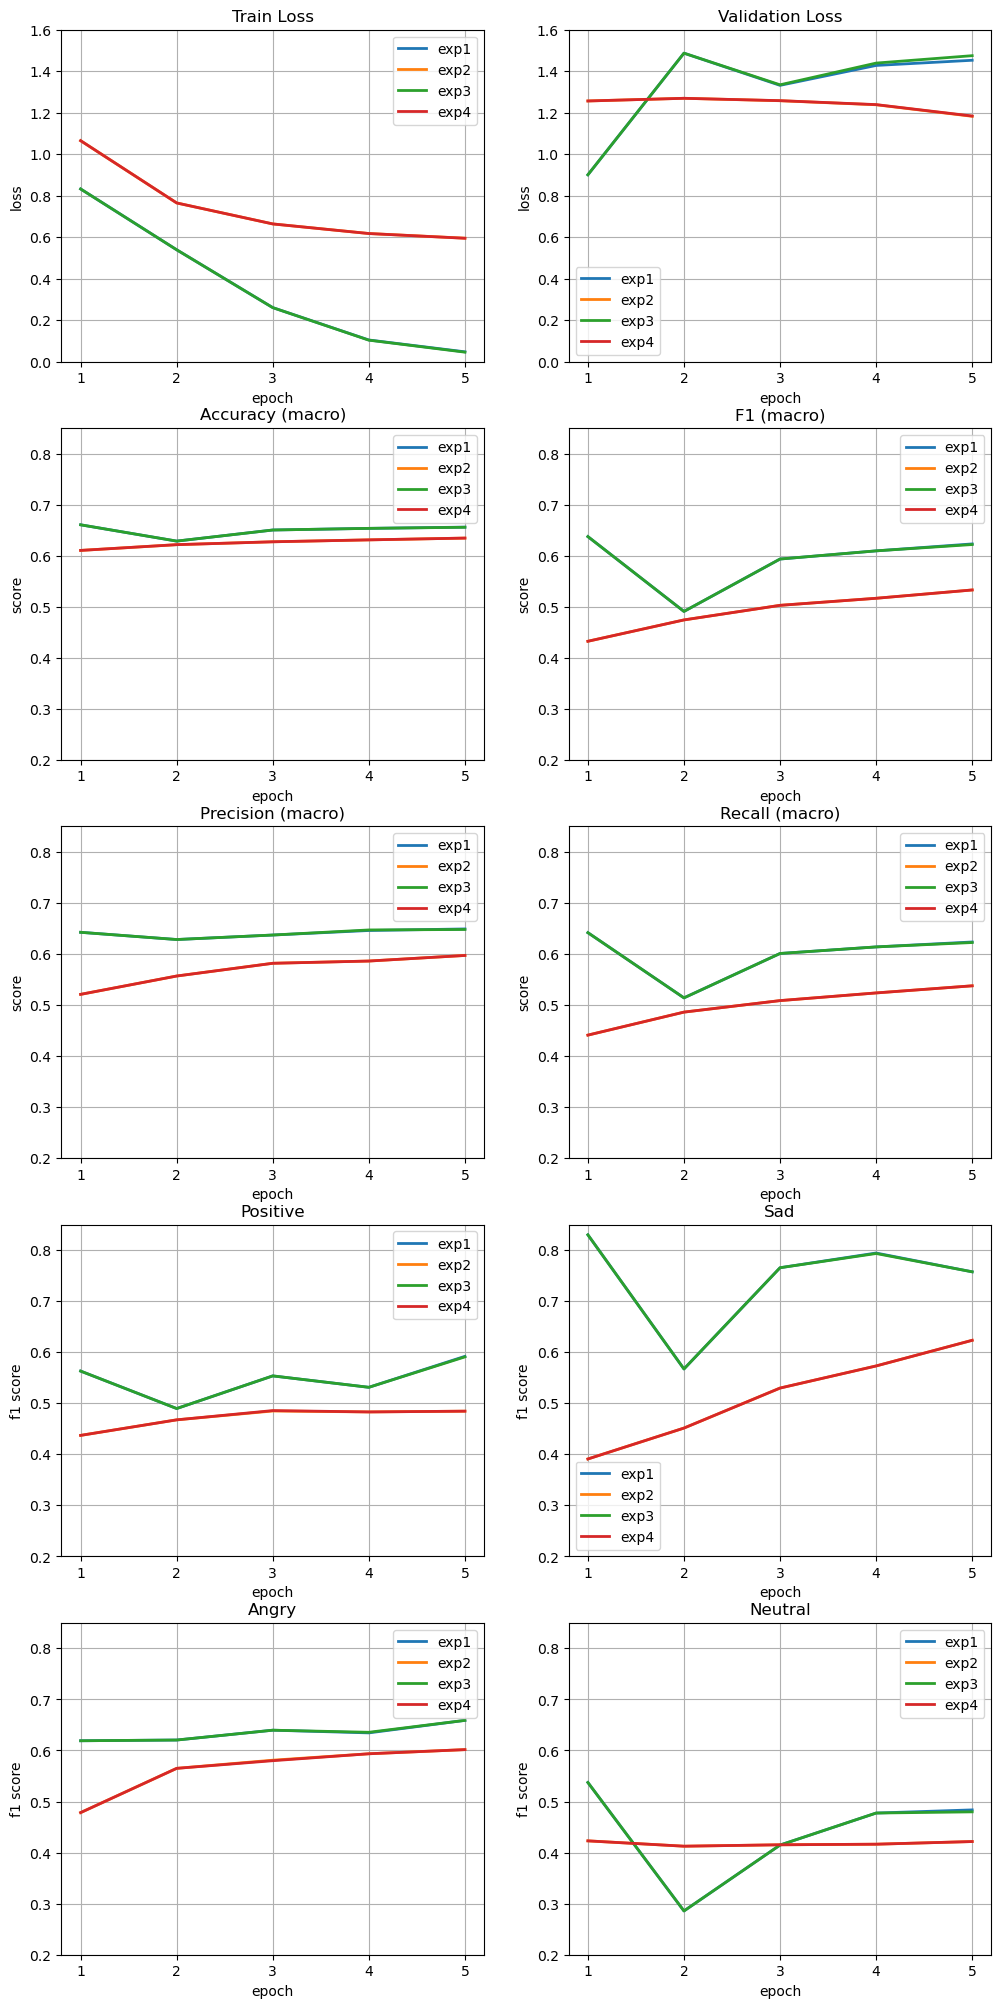

In [5]:
experiment_plots([1, 2, 3, 4], loss_ylim=[0, 1.6], score_ylim=[0.2, 0.85])

Стабильное обучение с наибольшими итоговыми значениями метрик на валидационной выборке показывает модель эксперимента 2 с данными гиперпараметрами:

- optimizer: Adam,
- scheduler: после 2 эпохи lr уменьшается в 2 раза каждую эпоху,
- base_lr: 1e-6.

Гиперпараметр `base_lr = 1e-5` (эксперименты 1 и 3) приводит к переобучению модели (значение потерь начинает расти после 2 эпози обучения).

Отличия при обучении трансформера и классификатора разными стратегиями не заметны в стравнении с обучением общей стратегией.

#### Группа 2: эксперименты 5-8

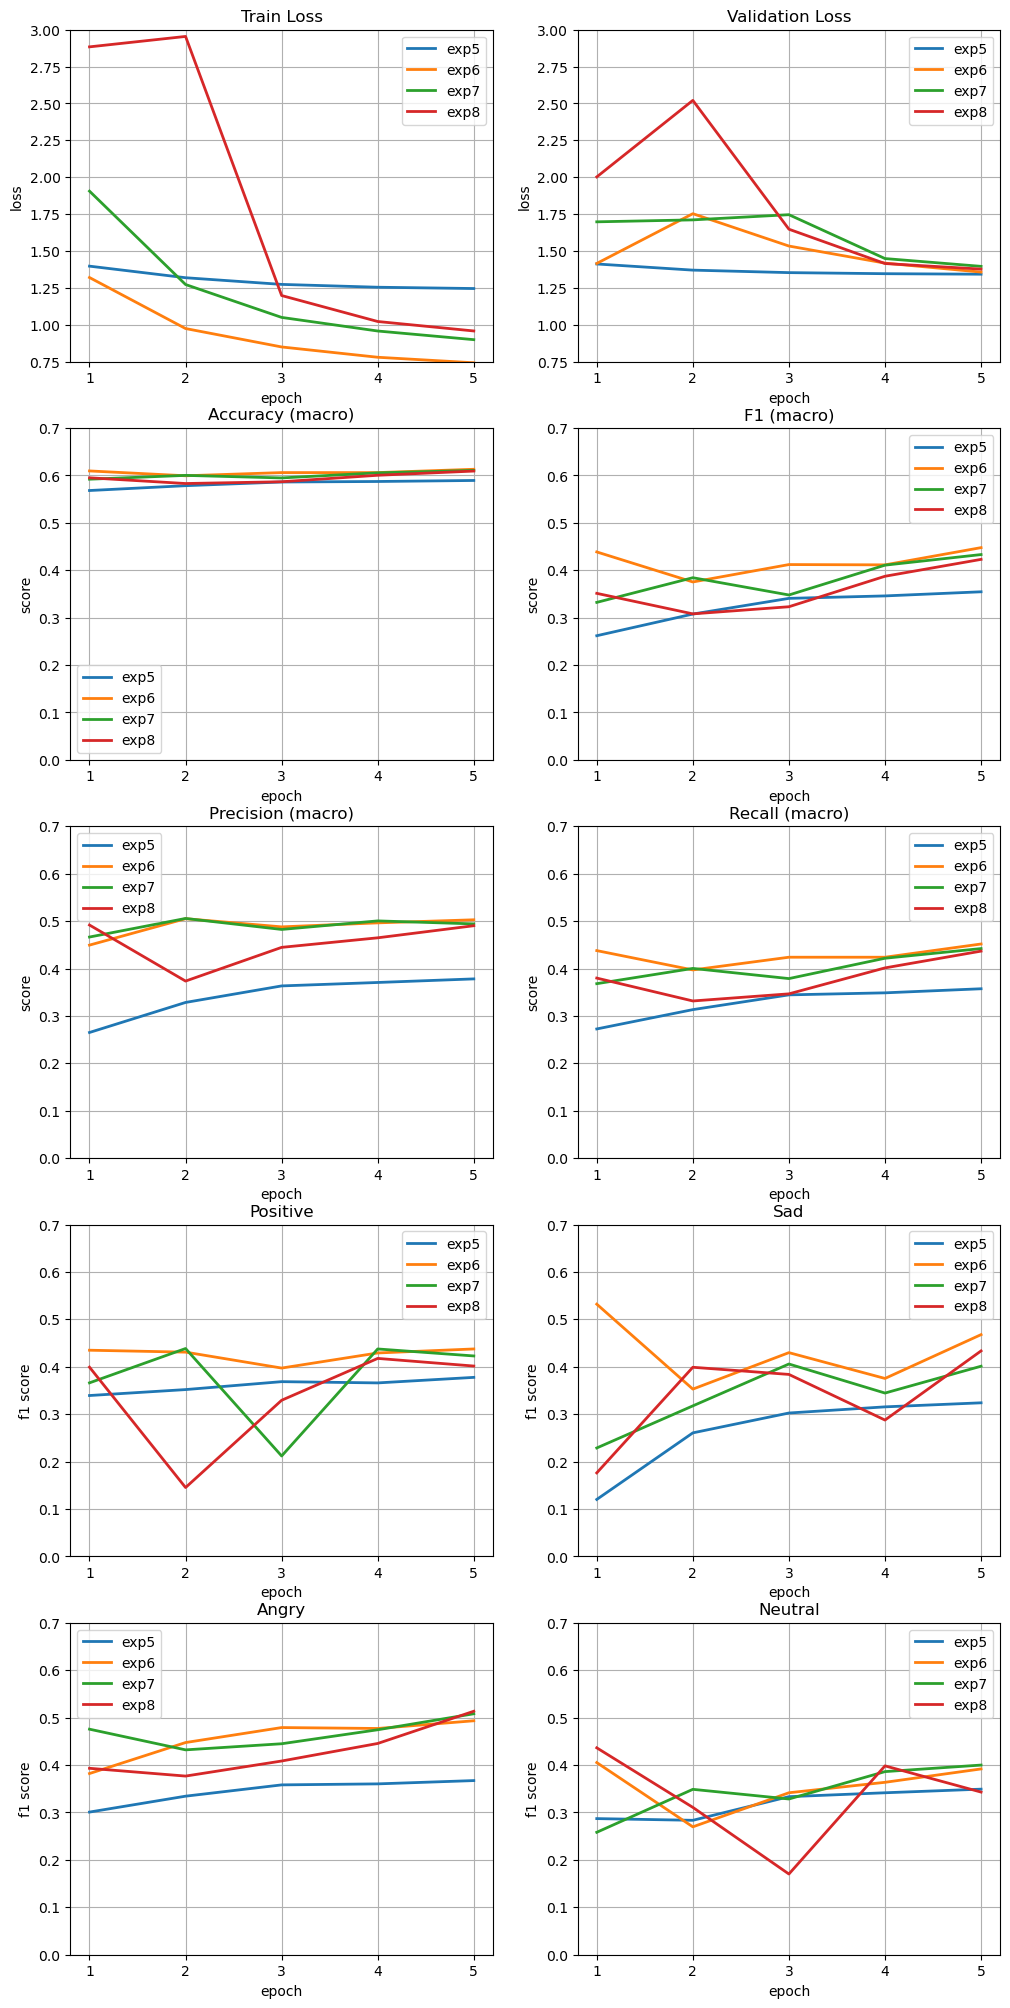

In [7]:
experiment_plots([5, 6, 7, 8], loss_ylim=[0.75, 3], score_ylim=[0, 0.7])

Стабильное обучение с наибольшими итоговыми значениями метрик на валидационной выборке показывает модель с параметром `lr = 1e-2` (эксперимент 6).

#### Группа 3: эксперимент 9

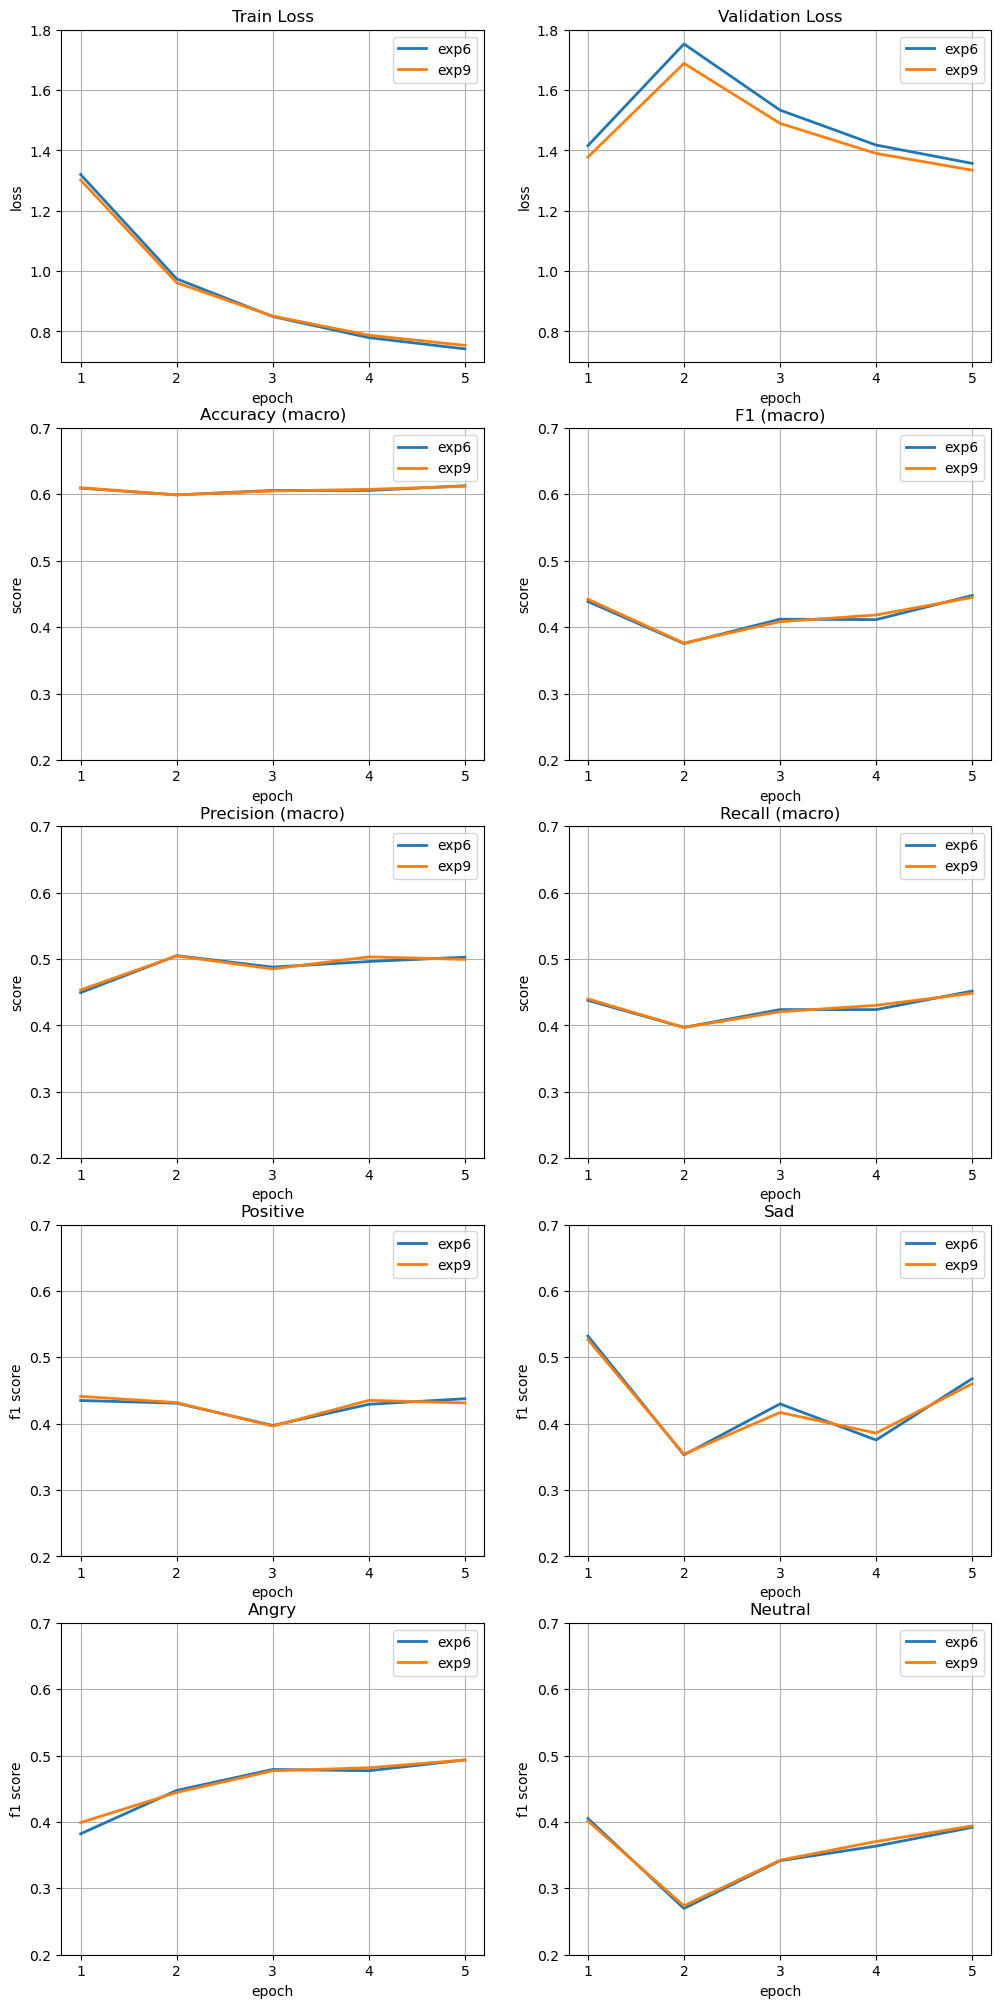

In [12]:
experiment_plots([6, 9], loss_ylim=[0.7, 1.8], score_ylim=[0.2, 0.7])

Результат обучения модели в эксперименте 9 показан в сравнении с результатом эксперимента 6, отобранного в предыдущей группе экспериентов. 

На построенных графиках заметных различий в значениях потерь и метриках при использовании оптимизатора AdamW, в сравнении с Adam.

#### Группа 4: эксперименты 10-11

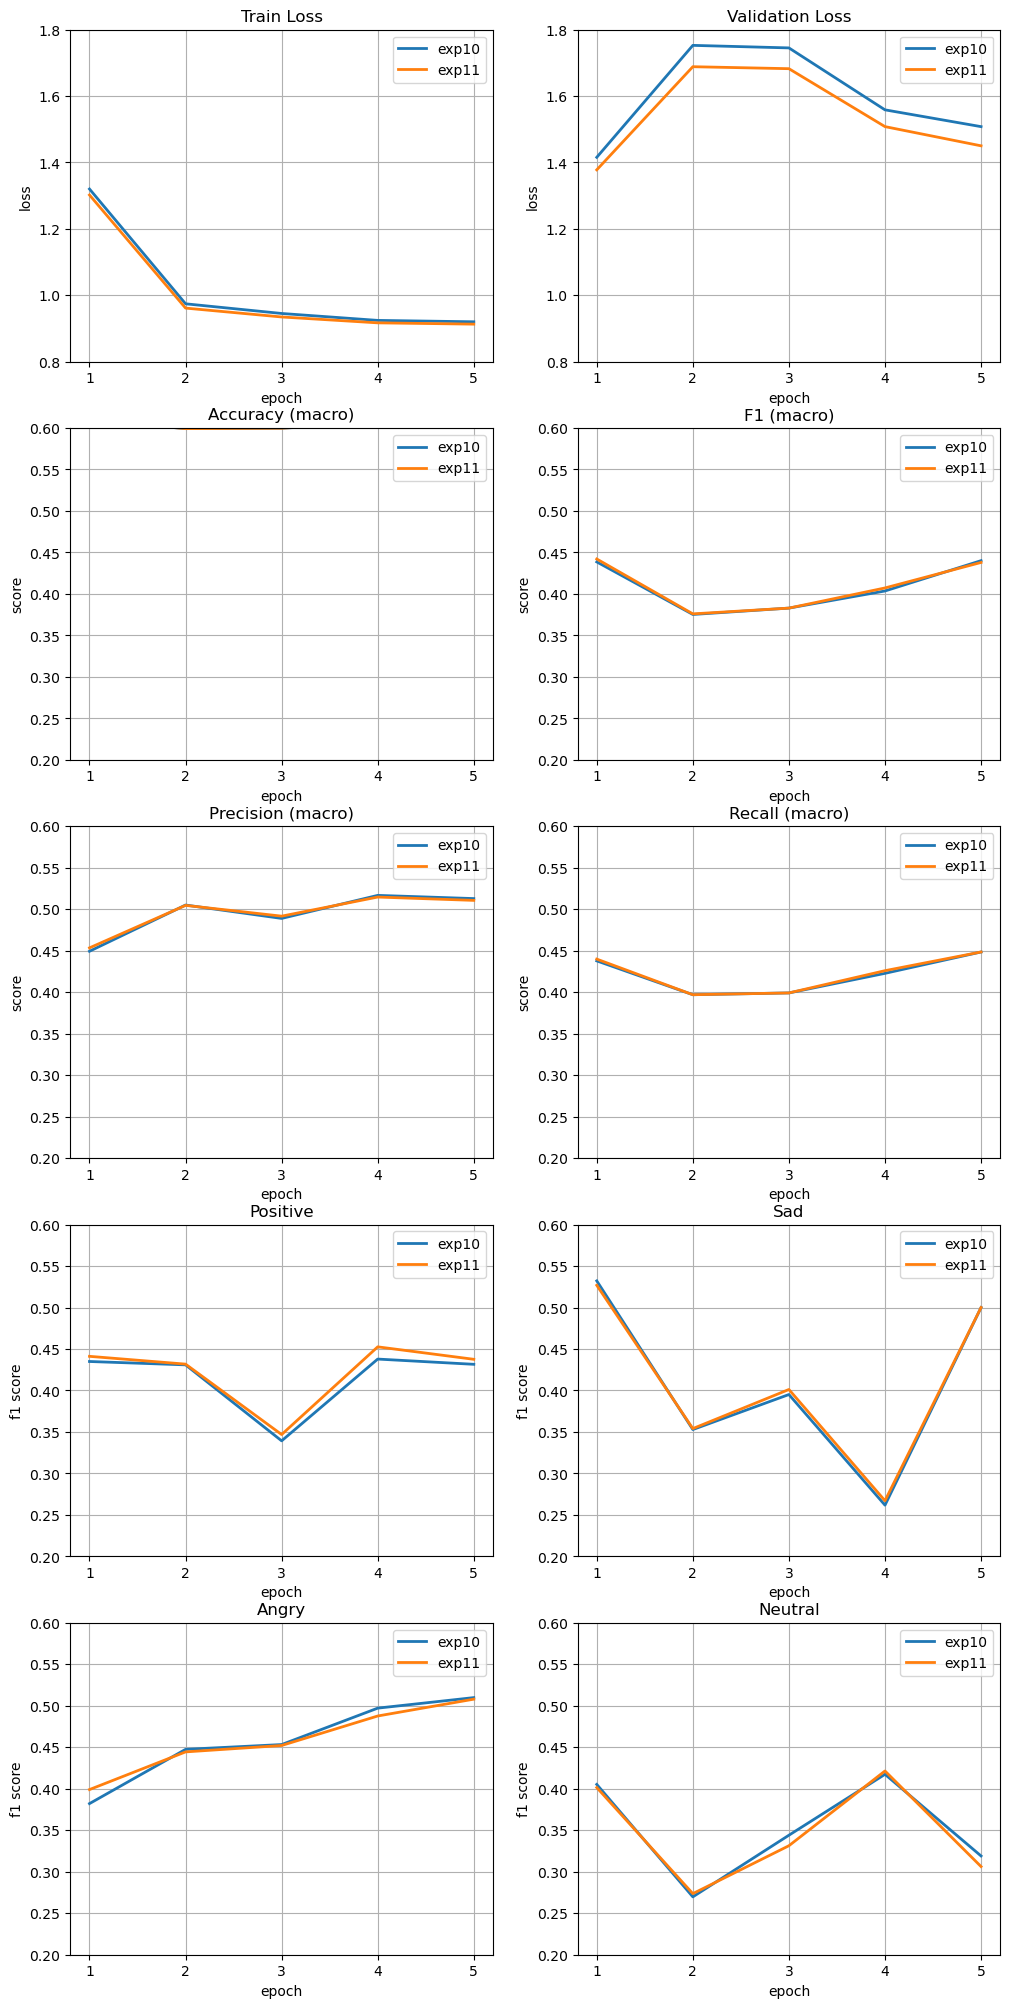

In [16]:
experiment_plots([10, 11], loss_ylim=[0.8, 1.8], score_ylim=[0.2, 0.6])

Аналагочно предыдущей группе экспериментов (3), заметных различий при использовании оптимизаторов Adam и AdamW нет.

#### Группа 5: эксперименты 12-13

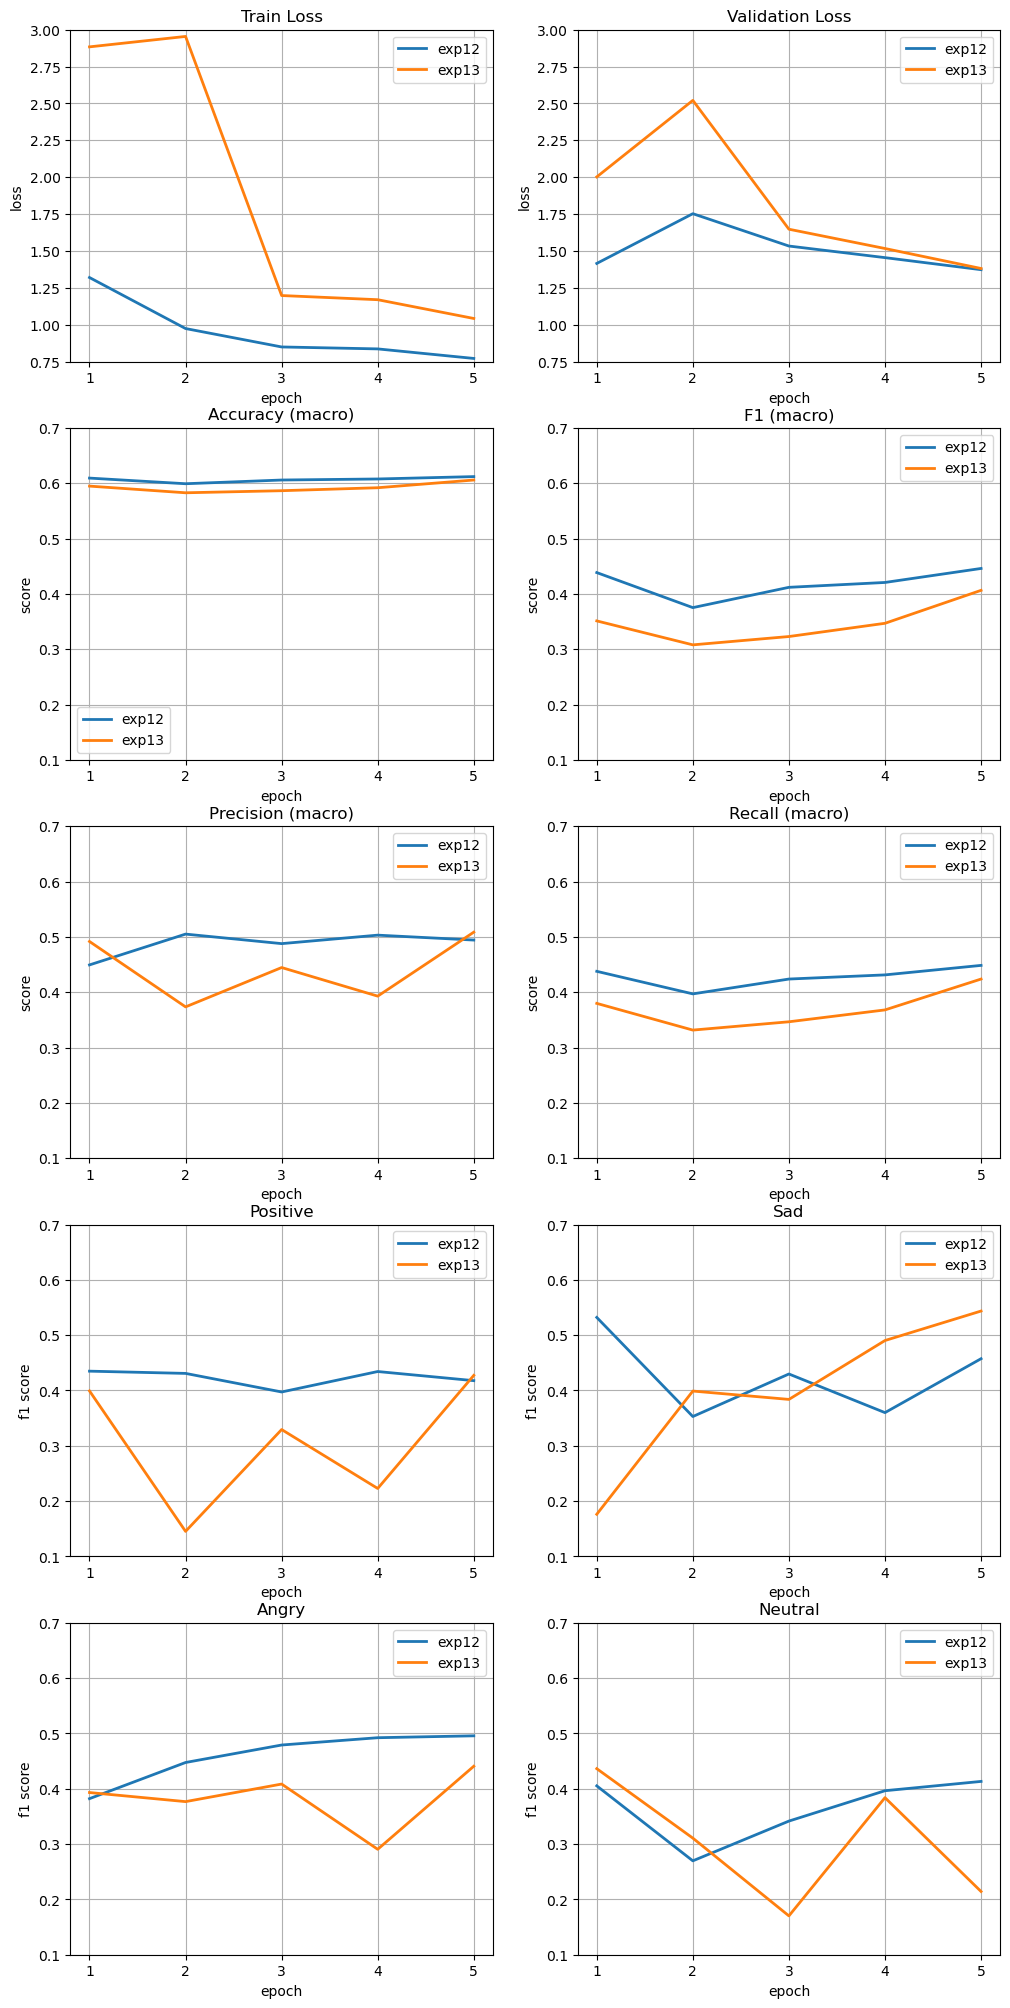

In [18]:
experiment_plots([12, 13], loss_ylim=[0.75, 3], score_ylim=[0.1, 0.7])

При использовании `base_lr = 1e-2` (эксперимент 12) получены более стабильные результаты и высокие значения метрик.

#### Группа 6: эксперименты 14-15

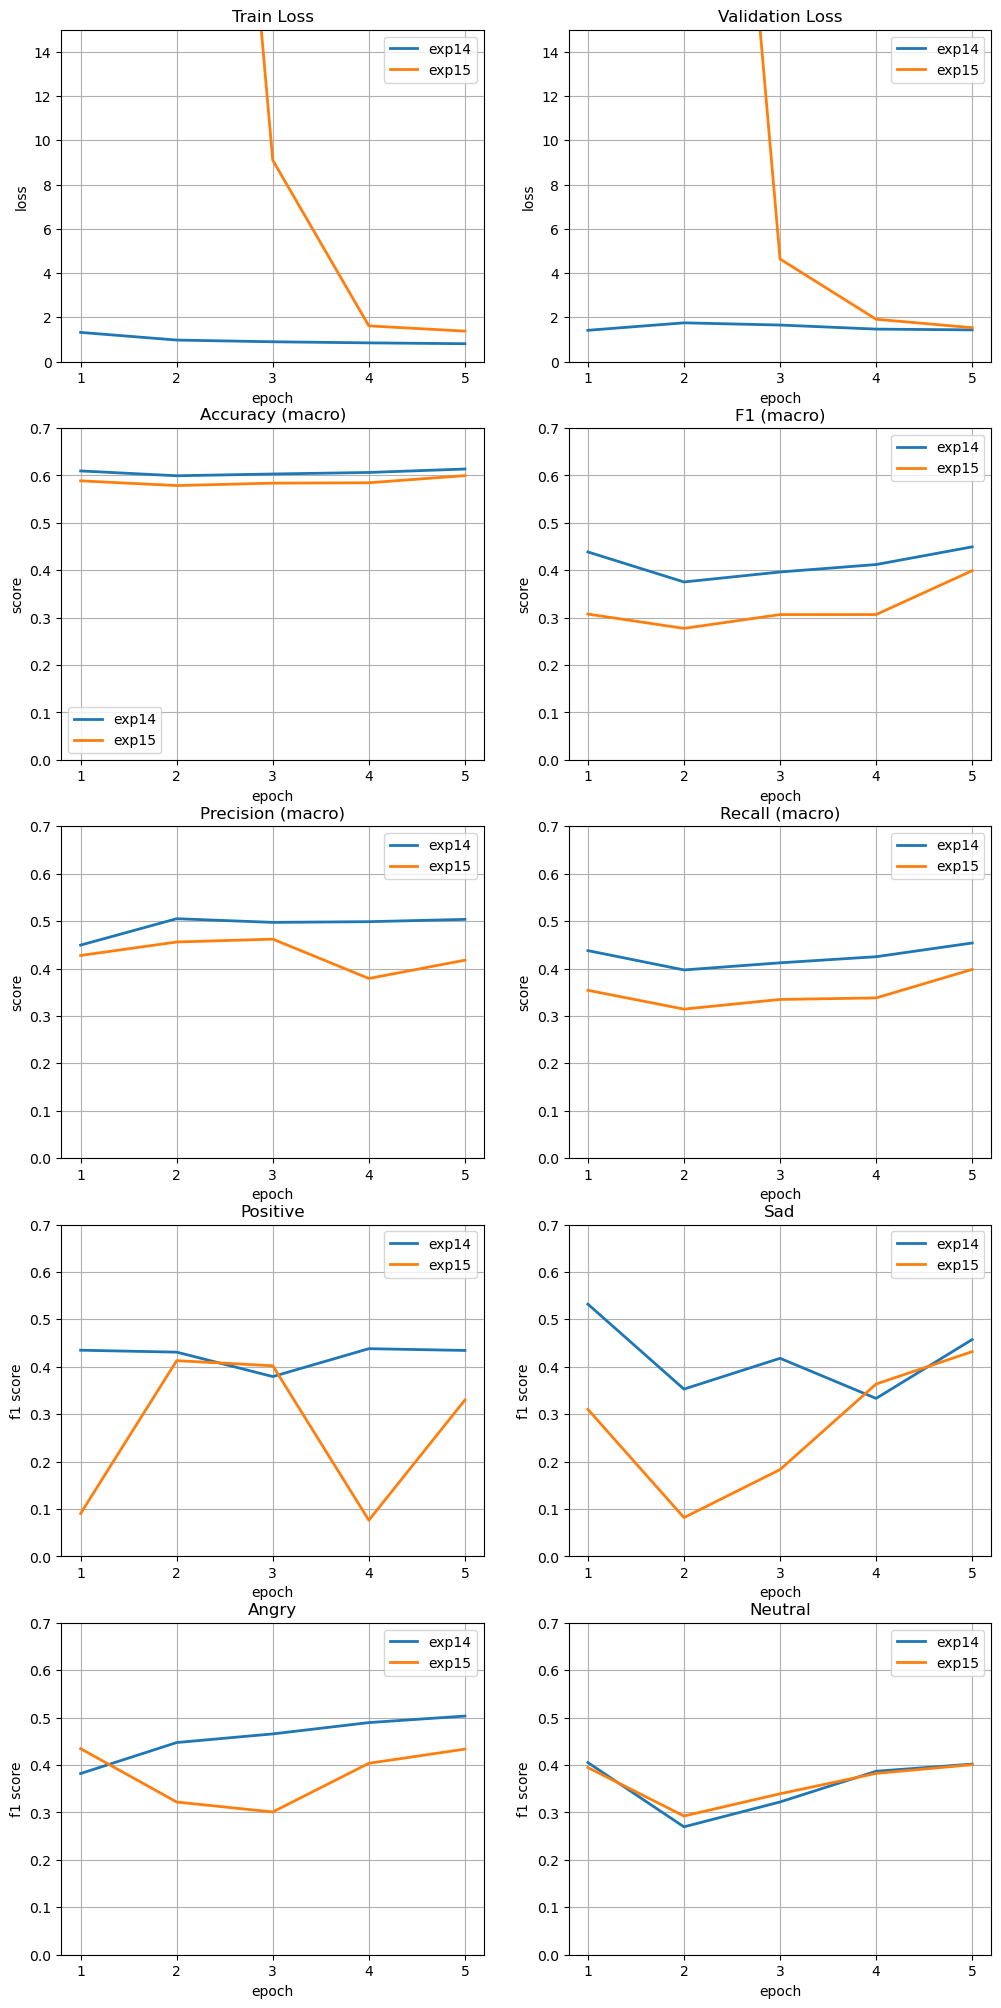

In [20]:
experiment_plots([14, 15], loss_ylim=[0, 15], score_ylim=[0, 0.7])

При использовании `base_lr = 1e-2` (эксперимент 14) получены более стабильные результаты и высокие значения метрик.

#### Сравнение лучших результатов из групп 2, 4, 5, 6 (обучение только классификатора)

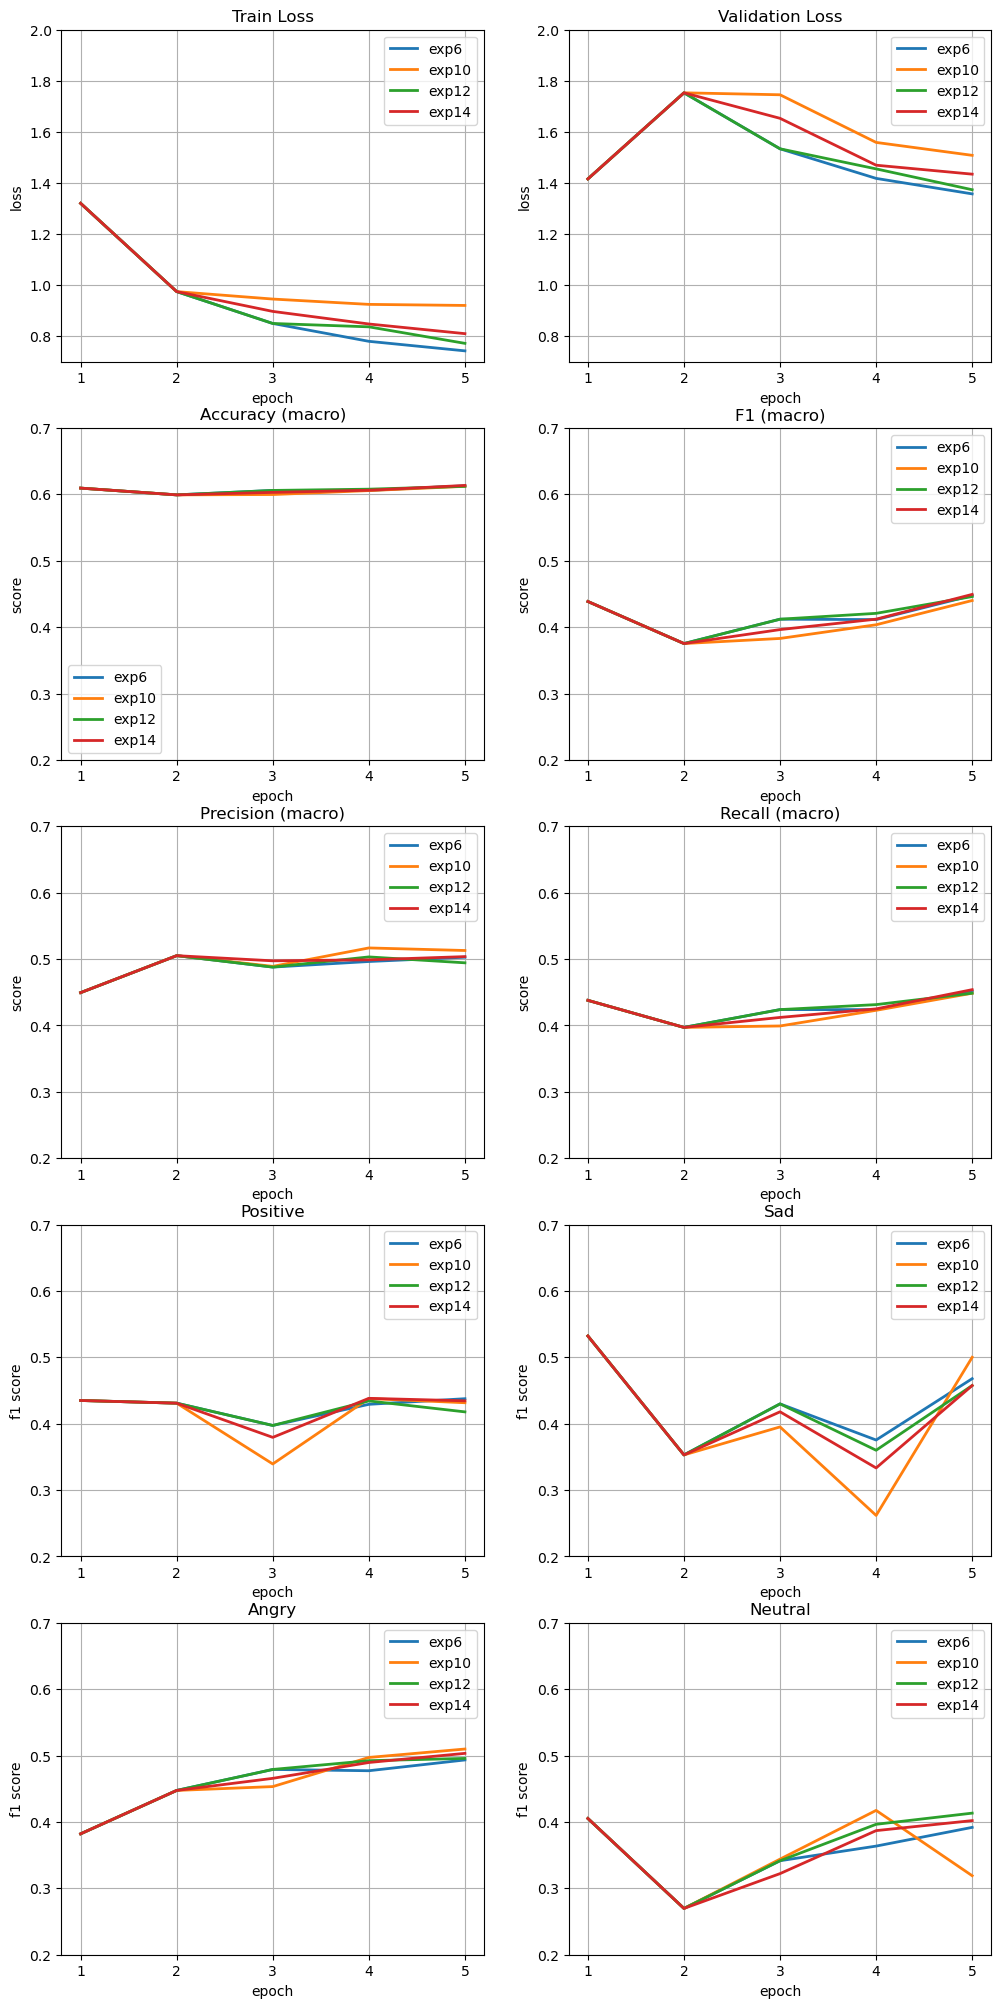

In [23]:
experiment_plots([6, 10, 12, 14], loss_ylim=[0.7, 2], score_ylim=[0.2, 0.7])

В группе экспериментов по обучению только классификатора модели наиболее стабильные результаты показала модель эксперимента 6.

### Сравнение результатов обучения всей модели и только классификатора

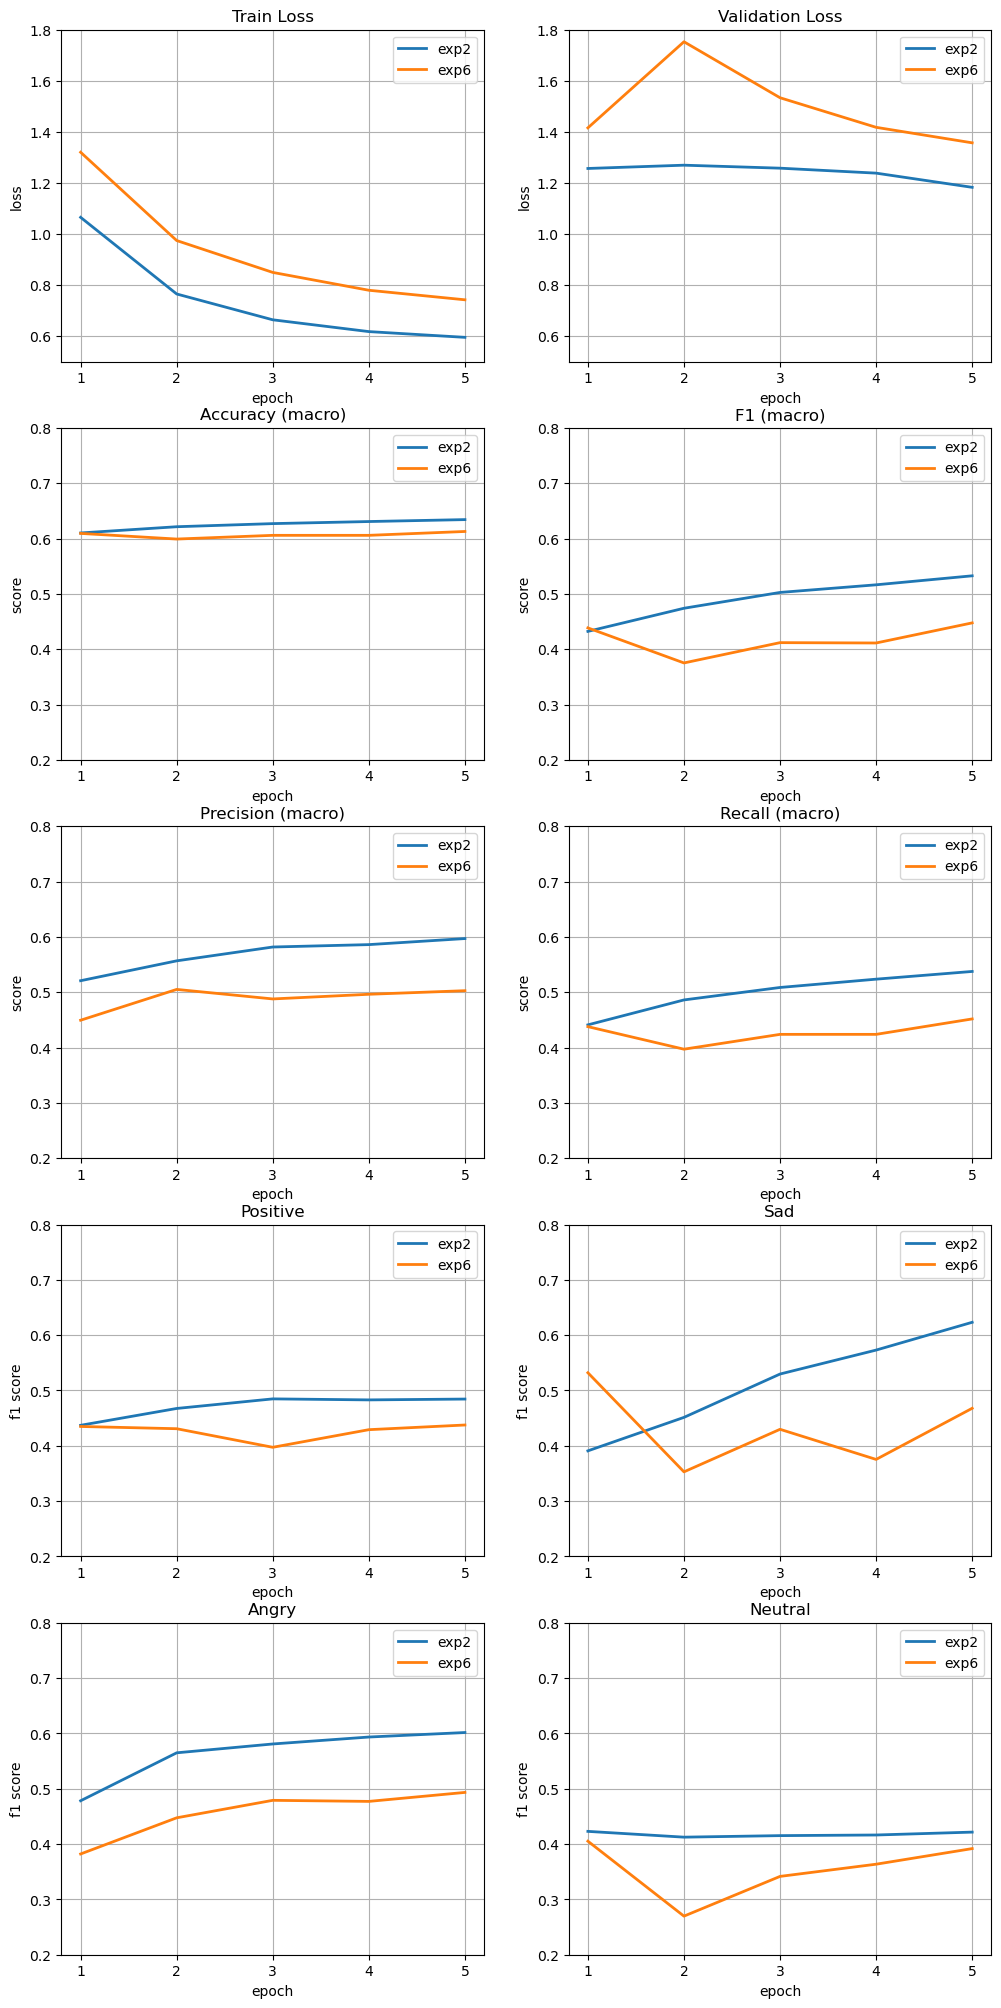

In [50]:
experiment_plots([2, 6], loss_ylim=[0.5, 1.8], score_ylim=[0.2, 0.8])

Модель из эксперимента 2 показывает более высокую точность.

### Оценка на тестовой выборке и сохранение лучшей модели

In [52]:
model = ASTForAudioClassification.from_pretrained(MODEL_PATH, num_labels=len(CLASSES), 
                                                  return_dict=False, ignore_mismatched_sizes=True)
experiment2_checkpoint_last = torch.load('ast_experiments/checkpoints/exp2/checkpoint5.pth')
print(experiment2_checkpoint_last.keys())
model.load_state_dict(experiment2_checkpoint_last['state_dict'])
model.to(device)
result_score_dict = test(model, ds, 3, device, CLASSES)
model.cpu()
model.save_pretrained('pytorch_model.bin')
gc.collect()
torch.cuda.empty_cache()

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


dict_keys(['state_dict', 'optimizer', 'scheduler'])


  0%|          | 0/272 [00:00<?, ?it/s]

In [53]:
result_score_dict

{'accuracy/macro_average': 0.6693251533742332,
 'precision/macro_average': 0.6793945881412666,
 'recall/macro_average': 0.6773640490679029,
 'f1/macro_average': 0.6752805959977297,
 'accuracy/positive': 0.6368098159509202,
 'precision/positive': 0.6150627615062761,
 'recall/positive': 0.7205882352941176,
 'f1/positive': 0.6636568848758465,
 'accuracy/sad': 0.6711656441717792,
 'precision/sad': 0.6995305164319249,
 'recall/sad': 0.7303921568627451,
 'f1/sad': 0.7146282973621103,
 'accuracy/angry': 0.6858895705521473,
 'precision/angry': 0.736318407960199,
 'recall/angry': 0.729064039408867,
 'f1/angry': 0.7326732673267327,
 'accuracy/neutral': 0.6834355828220859,
 'precision/neutral': 0.6666666666666666,
 'recall/neutral': 0.5294117647058824,
 'f1/neutral': 0.5901639344262295}

In [58]:
index = ['accuracy', 'precision', 'recall', 'f1']
pd.DataFrame({'macro_average': pd.Series([round(result_score_dict[idx+'/macro_average'], 3) for idx in index], index=index),
              'positive': pd.Series([round(result_score_dict[idx+'/positive'], 3) for idx in index], index=index),
              'sad': pd.Series([round(result_score_dict[idx+'/sad'], 3) for idx in index], index=index),
              'angry': pd.Series([round(result_score_dict[idx+'/angry'], 3) for idx in index], index=index),
              'neutral': pd.Series([round(result_score_dict[idx+'/neutral'], 3) for idx in index], index=index)
             }, index=index)

,macro_average,positive,sad,angry,neutral
accuracy,0.669,0.637,0.671,0.686,0.683
precision,0.679,0.615,0.700,0.736,0.667
recall,0.677,0.721,0.730,0.729,0.529
f1,0.675,0.664,0.715,0.733,0.590
